In [4]:
# Imports

import pandas as pd
import torch
import sys
import os
import random
import matplotlib.pyplot as plt
import numpy as np
# absolute path of the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)
from src.data_loader import load_data, preprocess_data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

In [5]:
# load dataset and preprocess sample of 10,000 rows of data
data_path = '../data/Electronics_5.json.gz'
full_df = load_data(data_path)

df_sample = full_df.sample(n=10000, random_state=42)
df_sample = preprocess_data(df_sample)

# display 5 random rows
print("Sample of the data:")
print(df_sample.sample(5))

Sample of the data:
                                                reviewText sentiment
3432959  This tablet holder is well built and functions...  positive
1881546  This cable works far better than I expected.  ...  positive
2320852  Haven't really noticed weather this is doing w...  positive
5436604  Great board.  After BIOS update that it.  I us...  positive
1806143                                    Nice protection  positive


In [6]:
# drop rows where reviewText is NaN
df_sample = df_sample.dropna(subset=['reviewText'])

# vectorize review text
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_sample['reviewText'])
y = df_sample['sentiment']

In [7]:
# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# use Logistic Regression for model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.74      0.40      0.52       235
     neutral       0.30      0.02      0.04       145
    positive       0.86      0.99      0.92      1619

    accuracy                           0.85      1999
   macro avg       0.63      0.47      0.49      1999
weighted avg       0.80      0.85      0.81      1999



In [9]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, max_length=self.max_len, truncation=True,
            padding='max_length', return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_dataloader(df, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(
        texts=df['reviewText'].tolist(),
        labels=df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0}).tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def load_distilbert_model():
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
    return tokenizer, model

In [10]:
# device config
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available()  # For Mac M1/M2 users
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [11]:
# load tokenizer and model
tokenizer, model = load_distilbert_model()
model = model.to(device)

# dataloader
train_loader = create_dataloader(df_sample, tokenizer, max_len=256, batch_size=16)

# optimizer / scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# training loop
for epoch in range(6):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/fg/rs2ldmzd1d7bbxjkqpsbjt500000gn/T/ipykernel_92284/233358881.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels=df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0}).tolist(),
/opt/anaconda3/envs/sentiment_analyzer/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version.

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1, Loss: 0.3905614971756935


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2, Loss: 0.25306937140226365


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3, Loss: 0.17196662685126066


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4, Loss: 0.11872472215313465


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5, Loss: 0.08021415469348431


Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0621736615116708


In [12]:
# Split the data
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)

# Create test DataLoader
test_loader = create_dataloader(test_df, tokenizer, max_len=128, batch_size=8)

/var/folders/fg/rs2ldmzd1d7bbxjkqpsbjt500000gn/T/ipykernel_92284/233358881.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels=df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0}).tolist(),


In [13]:
# Store predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        # Store results
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions and labels to sentiment labels
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
pred_sentiments = [label_map[pred] for pred in all_preds]
true_sentiments = [label_map[label] for label in all_labels]

# Show classification report
print(classification_report(true_sentiments, pred_sentiments))

              precision    recall  f1-score   support

    negative       0.95      0.96      0.95       235
     neutral       0.88      0.85      0.87       145
    positive       0.99      0.99      0.99      1619

    accuracy                           0.97      1999
   macro avg       0.94      0.93      0.94      1999
weighted avg       0.97      0.97      0.97      1999



In [14]:
# Randomly pick 5 reviews from the test set
sample_indices = random.sample(range(len(test_df)), 5)
sample_reviews = test_df.iloc[sample_indices]

# Predict the sentiment for these reviews
for i, row in sample_reviews.iterrows():
    input_ids = tokenizer.encode(row['reviewText'], truncation=True, padding='max_length', max_length=128, return_tensors='pt').to(device)
    
    # Get prediction
    output = model(input_ids, attention_mask=(input_ids > 0).int())
    pred_label = torch.argmax(output.logits, dim=1).item()
    
    print(f"Review: {row['reviewText']}")
    print(f"Actual Sentiment: {row['sentiment']}")
    print(f"Predicted Sentiment: {label_map[pred_label]}")
    print("-" * 80)

Review: Mine is already breaking after a few weeks of use. It has very cheap legs that get STUCK when you extend them. Very annoying

UPDATE: NOW THE BALL HEAD IS BROKEN AND WON'T HOLD MY CAMERA UP!! So the tripod is effectively USELESS!! COMPLETE WASTE OF $160!!!!!!
Actual Sentiment: negative
Predicted Sentiment: negative
--------------------------------------------------------------------------------
Review: It is still fairly new for me, but definitely met my expectations.  Windows 7 Pro Performs nicely and the equipment seems well designed and built by Lenovo.  Too new to review reliability.
Actual Sentiment: positive
Predicted Sentiment: positive
--------------------------------------------------------------------------------
Review: This is an average mp3 player but not so good when compared to previous iterations (I've owned a Clip+ and a Clip zip, both  being awesome players). I bought this for my girlfriend and it's OK for her intended use (easy to use low-cost mp3) and it com

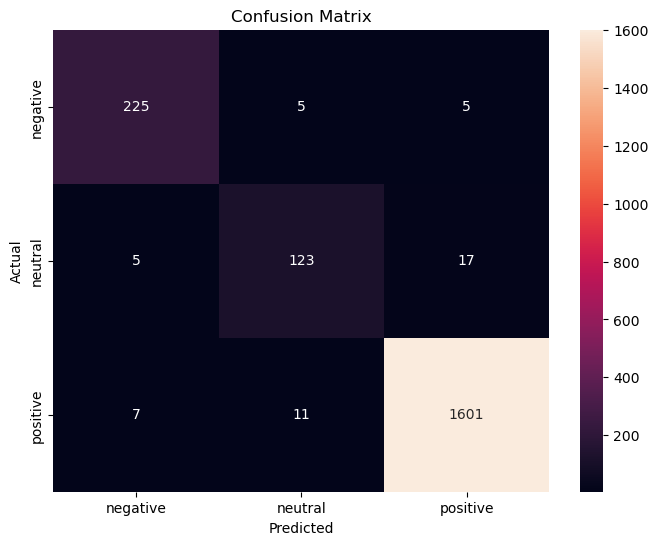

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_sentiments, pred_sentiments, labels=['negative', 'neutral', 'positive'])

# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
model.save_pretrained("./sentimental_reviews_model")
tokenizer.save_pretrained("./sentimental_reviews_model")

('./sentimental_reviews_model/tokenizer_config.json',
 './sentimental_reviews_model/special_tokens_map.json',
 './sentimental_reviews_model/vocab.txt',
 './sentimental_reviews_model/added_tokens.json')

In [17]:

# Convert the TF-IDF matrix to an array
tfidf_array = X.toarray()

# Create a DataFrame mapping each word to its TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf.get_feature_names_out())
tfidf_df['sentiment'] = y.values

# Compute the average TF-IDF score per word, grouped by sentiment
word_importance = (
    tfidf_df.groupby('sentiment').mean().T
    .rename(columns={'negative': 'Negative', 'neutral': 'Neutral', 'positive': 'Positive'})
)

# Find the most important words for each sentiment
top_negative = word_importance.sort_values('Negative', ascending=False).head(10)
top_neutral = word_importance.sort_values('Neutral', ascending=False).head(10)
top_positive = word_importance.sort_values('Positive', ascending=False).head(10)

print("Top 10 words for Negative Sentiment:\n", top_negative)
print("\nTop 10 words for Neutral Sentiment:\n", top_neutral)
print("\nTop 10 words for Positive Sentiment:\n", top_positive)

Top 10 words for Negative Sentiment:
 sentiment  Negative   Neutral  Positive
the        0.119048  0.127753  0.086613
it         0.082890  0.085368  0.062856
to         0.068624  0.072375  0.055020
and        0.058597  0.051706  0.060506
not        0.056666  0.045585  0.016894
is         0.046508  0.053580  0.039125
this       0.043926  0.037784  0.037431
of         0.042578  0.039835  0.030137
for        0.034966  0.046655  0.040585
was        0.034161  0.023381  0.020163

Top 10 words for Neutral Sentiment:
 sentiment  Negative   Neutral  Positive
the        0.119048  0.127753  0.086613
it         0.082890  0.085368  0.062856
to         0.068624  0.072375  0.055020
is         0.046508  0.053580  0.039125
and        0.058597  0.051706  0.060506
for        0.034966  0.046655  0.040585
but        0.031142  0.045776  0.020579
not        0.056666  0.045585  0.016894
of         0.042578  0.039835  0.030137
this       0.043926  0.037784  0.037431

Top 10 words for Positive Sentiment:
 senti

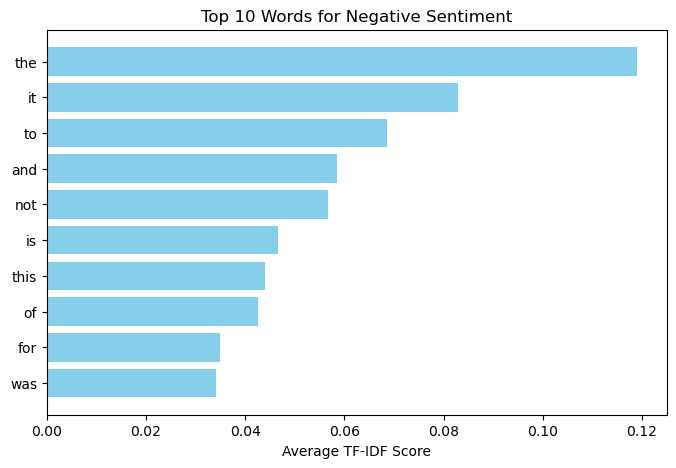

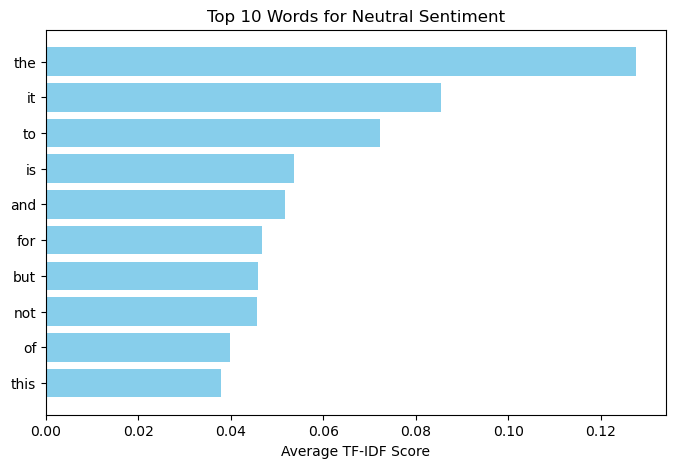

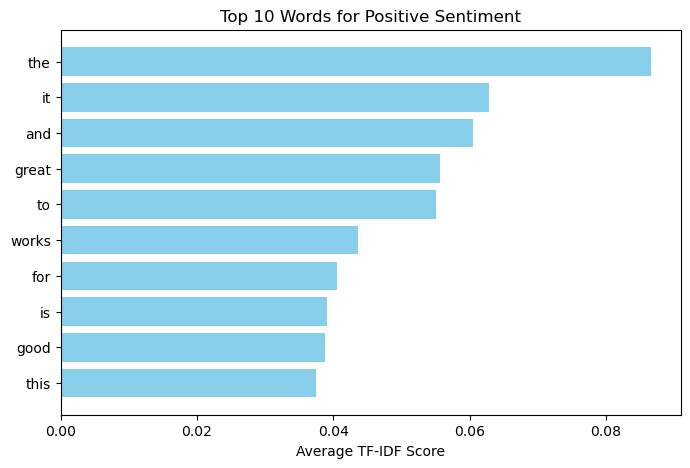

In [18]:
top_words = {
    'Negative': top_negative,
    'Neutral': top_neutral,
    'Positive': top_positive
}

for sentiment, data in top_words.items():
    plt.figure(figsize=(8, 5))
    plt.barh(data.index, data[sentiment], color='skyblue')
    plt.xlabel('Average TF-IDF Score')
    plt.title(f'Top 10 Words for {sentiment} Sentiment')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
    plt.show()

In [19]:
positive_words = set(top_positive.index)
negative_words = set(top_negative.index)

def heuristic_classifier(text):
    words = set(text.lower().split())
    if len(words & positive_words) > len(words & negative_words):
        return 'positive'
    elif len(words & negative_words) > len(words & positive_words):
        return 'negative'
    else:
        return 'neutral'

# Test the heuristic classifier
sample_reviews = test_df['reviewText'].sample(5).tolist()
for review in sample_reviews:
    print("Review:", review)
    print("Heuristic Prediction:", heuristic_classifier(review))
    print("-" * 80)

Review: I received the item promptly, opened the box, it appeared as if it had been opened and used before. Installed the battery and attempted to charge it. After the recomended two hours as stated in the instructions I removed the unit from chariging cord and tried to turn it on. It did NOT work. I plugged it back in and tried again, it came on only when plugged in to power. I checked the battery with a Volt/Ohm meter and the battery was charged but appearantly the fault was in the camera. Be cautious the units at vastly reduced prices from unreliable sources. FGorunatly it was honored for return by Amazon A to Z and they paid for retun shipping and said they would credit back my money... We will see.
Heuristic Prediction: negative
--------------------------------------------------------------------------------
Review: I am currently using 5 different HDMI cables, ranging in price from a few cents up to $40 dollars. One thing I have learned is that price doesn't matter, they all do t

In [20]:
model.save_pretrained("./results/sentimental_reviews_model")
tokenizer.save_pretrained("./results/sentimental_reviews_model")

('./results/sentimental_reviews_model/tokenizer_config.json',
 './results/sentimental_reviews_model/special_tokens_map.json',
 './results/sentimental_reviews_model/vocab.txt',
 './results/sentimental_reviews_model/added_tokens.json')

In [21]:
top_negative.to_csv('./results/top_negative_words.csv')
top_neutral.to_csv('./results/top_neutral_words.csv')
top_positive.to_csv('./results/top_positive_words.csv')